# Setup workspace

In [280]:
import time, json, glob, os, itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np

from py2neo import Graph, Node, Relationship
from tqdm.autonotebook import tqdm
from __future__ import print_function

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

# Query and format data

## Connect to graph

In [281]:
graph = Graph("bolt://matlaber5.media.mit.edu:7687", auth=('neo4j','myneo'))

n_nodes = len(graph.nodes)
n_edges = len(graph.relationships)
print("Connected to graph with {:,} nodes and {:,} edges!".format(n_nodes, n_edges))

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False, verbose=True):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    if verbose:
        print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

nobel_winners_file = 'nobelwinners.csv'
nobel_citations_file = 'nobelcitations.csv'
n_years_to_track = 15

Connected to graph with 278,076,495 nodes and 1,842,505,331 edges!


## Query graph for each Nobel prize winner

In [285]:
nobel_winners = pd.read_csv(nobel_winners_file)

citation_fun = lambda x: 'size((:Quanta {{{{year:q.year+{}}}}})-[:CITES]->(q)) as c{}'.format(x,x)
citation_str = ',\n'.join([citation_fun(i) for i in range(n_years_to_track)])
query_str = """
MATCH (a:Author)-[:AUTHORED]->(q:Quanta)
WHERE a.name="{}" AND q.year>{} AND q.year<{}
WITH q, size((:Quanta)-[:CITES]->(q)) as numCitations
WHERE numCitations>500
RETURN q.title as title, q.year as year, numCitations,
""" + citation_str + "\nORDER BY numCitations DESC"

ndf = pd.DataFrame()

for i, row in tqdm(list(nobel_winners.iterrows())):
    if row['Laureate Type'] == 'Individual':
        
        year = row['Year']
        category = row['Category']
        name = row['Full Name']
        birth = row['Birth Date'][:4] if not pd.isna(row['Birth Date']) else np.nan 
        death = row['Death Date'][:4] if not pd.isna(row['Death Date']) else np.nan 
        print("{}: {} in {}...".format(year, name, category))
        
        query = query_str.format(name, 
                                 birth if not pd.isna(birth) else 1500, 
                                 death if not pd.isna(death) else 2019-n_years_to_track)
        df = run_query(query, graph, to_df=True, verbose=False, print_only=False)

        df['prizeCategory'] = category
        df['prizeYear'] = year
        df['prizeName'] = name
        df['prizeBirth'] = birth
        df['prizeDeath'] = death

        ndf = ndf.append(df, sort=False)
        
ndf.drop_duplicates(keep='first', inplace=True)
ndf.to_csv(nobel_citations_file)

1901: Jacobus Henricus van 't Hoff in Chemistry...
1901: Sully Prudhomme in Literature...
1901: Emil Adolf von Behring in Medicine...
1901: Jean Henry Dunant in Peace...
1901: Frédéric Passy in Peace...
1901: Wilhelm Conrad Röntgen in Physics...
1902: Hermann Emil Fischer in Chemistry...
1902: Christian Matthias Theodor Mommsen in Literature...
1902: Ronald Ross in Medicine...
1902: Élie Ducommun in Peace...
1902: Charles Albert Gobat in Peace...
1902: Hendrik Antoon Lorentz in Physics...
1902: Pieter Zeeman in Physics...
1903: Svante August Arrhenius in Chemistry...
1903: Bjørnstjerne Martinus Bjørnson in Literature...
1903: Niels Ryberg Finsen in Medicine...
1903: William Randal Cremer in Peace...
1903: Antoine Henri Becquerel in Physics...
1903: Pierre Curie in Physics...
1903: Marie Curie, née Sklodowska in Physics...
1904: Sir William Ramsay in Chemistry...
1904: Frédéric Mistral in Literature...
1904: José Echegaray y Eizaguirre in Literature...
1904: Ivan Petrovich Pavlov in Med

1937: Paul Karrer in Chemistry...
1937: Roger Martin du Gard in Literature...
1937: Albert von Szent-Györgyi Nagyrápolt in Medicine...
1937: Cecil of Chelwood, Viscount (Lord Edgar Algernon Robert Gascoyne Cecil) in Peace...
1937: Clinton Joseph Davisson in Physics...
1937: George Paget Thomson in Physics...
1938: Richard Kuhn in Chemistry...
1938: Richard Kuhn in Chemistry...
1938: Pearl Buck in Literature...
1938: Corneille Jean François Heymans in Medicine...
1938: Enrico Fermi in Physics...
1939: Adolf Friedrich Johann Butenandt in Chemistry...
1939: Adolf Friedrich Johann Butenandt in Chemistry...
1939: Leopold Ruzicka in Chemistry...
1939: Frans Eemil Sillanpää in Literature...
1939: Gerhard Domagk in Medicine...
1939: Ernest Orlando Lawrence in Physics...
1943: George de Hevesy in Chemistry...
1943: Henrik Carl Peter Dam in Medicine...
1943: Edward Adelbert Doisy in Medicine...
1943: Otto Stern in Physics...
1944: Otto Hahn in Chemistry...
1944: Johannes Vilhelm Jensen in Litera

1967: Hans Albrecht Bethe in Physics...
1968: Lars Onsager in Chemistry...
1968: Yasunari Kawabata in Literature...
1968: Robert W. Holley in Medicine...
1968: Har Gobind Khorana in Medicine...
1968: Marshall W. Nirenberg in Medicine...
1968: René Cassin in Peace...
1968: Luis Walter Alvarez in Physics...
1969: Derek H. R. Barton in Chemistry...
1969: Odd Hassel in Chemistry...
1969: Ragnar Frisch in Economics...
1969: Jan Tinbergen in Economics...
1969: Samuel Beckett in Literature...
1969: Max Delbrück in Medicine...
1969: Alfred D. Hershey in Medicine...
1969: Salvador E. Luria in Medicine...
1969: Murray Gell-Mann in Physics...
1970: Luis F. Leloir in Chemistry...
1970: Paul A. Samuelson in Economics...
1970: Aleksandr Isayevich Solzhenitsyn in Literature...
1970: Sir Bernard Katz in Medicine...
1970: Ulf von Euler in Medicine...
1970: Julius Axelrod in Medicine...
1970: Norman E. Borlaug in Peace...
1970: Hannes Olof Gösta Alfvén in Physics...
1970: Louis Eugène Félix Néel in Phys

1990: Harry M. Markowitz in Economics...
1990: Merton H. Miller in Economics...
1990: William F. Sharpe in Economics...
1990: Octavio Paz in Literature...
1990: Joseph E. Murray in Medicine...
1990: E. Donnall Thomas in Medicine...
1990: Mikhail Sergeyevich Gorbachev in Peace...
1990: Jerome I. Friedman in Physics...
1990: Henry W. Kendall in Physics...
1990: Richard E. Taylor in Physics...
1991: Richard R. Ernst in Chemistry...
1991: Ronald H. Coase in Economics...
1991: Nadine Gordimer in Literature...
1991: Erwin Neher in Medicine...
1991: Bert Sakmann in Medicine...
1991: Pierre-Gilles de Gennes in Physics...
1992: Rudolph A. Marcus in Chemistry...
1992: Gary S. Becker in Economics...
1992: Derek Walcott in Literature...
1992: Edmond H. Fischer in Medicine...
1992: Edwin G. Krebs in Medicine...
1992: Rigoberta Menchú Tum in Peace...
1992: Georges Charpak in Physics...
1992: Georges Charpak in Physics...
1993: Kary B. Mullis in Chemistry...
1993: Michael Smith in Chemistry...
1993: 

2008: Toshihide Maskawa in Physics...
2008: Toshihide Maskawa in Physics...
2009: Venkatraman Ramakrishnan in Chemistry...
2009: Thomas A. Steitz in Chemistry...
2009: Thomas A. Steitz in Chemistry...
2009: Ada E. Yonath in Chemistry...
2009: Elinor Ostrom in Economics...
2009: Elinor Ostrom in Economics...
2009: Oliver E. Williamson in Economics...
2009: Herta Müller in Literature...
2009: Elizabeth H. Blackburn in Medicine...
2009: Carol W. Greider in Medicine...
2009: Jack W. Szostak in Medicine...
2009: Jack W. Szostak in Medicine...
2009: Jack W. Szostak in Medicine...
2009: Barack H. Obama in Peace...
2009: Charles Kuen Kao in Physics...
2009: Charles Kuen Kao in Physics...
2009: Willard S. Boyle in Physics...
2009: George E. Smith in Physics...
2010: Richard F. Heck in Chemistry...
2010: Ei-ichi Negishi in Chemistry...
2010: Akira Suzuki in Chemistry...
2010: Peter A. Diamond in Economics...
2010: Dale T. Mortensen in Economics...
2010: Dale T. Mortensen in Economics...
2010: Ch

## Structure data

In [477]:
# Read in nobel citations file 
ndf = pd.read_csv(nobel_citations_file)
print("Starting with {} papers... ".format(len(ndf)), end='')

# Filter data
min_year = 1900
max_year = 2000
min_citations = 500

prize_mask = (ndf['prizeYear']>=min_year) & (ndf['prizeYear']<max_year)
cite_mask = (ndf['numCitations']>min_citations)
cat_mask = (ndf['prizeCategory']) != 'Literature'
pub_mask = (ndf['year']>=min_year) & (ndf['year']<ndf['prizeYear'])
ndf = ndf.loc[prize_mask & cite_mask & cat_mask & pub_mask,:].copy(deep=True)

# Add features
ndf['type'] = 'Nobel'
ndf['prizeDecade'] = 0
ndf['pubDecade'] = 0
for decade in range(min_year, max_year-1, 10):
    mask = (ndf['prizeYear'] >= decade) & (ndf['prizeYear'] < decade+10)
    ndf.loc[mask, 'prizeDecade'] = decade
    
    mask = (ndf['year'] >= decade) & (ndf['year'] < decade+10)
    ndf.loc[mask, 'pubDecade'] = decade
    
# Relabel columns
def relabel_columns(df):
    cols = df.columns
    for i in range(n_years_to_track):
        cols = [i if x=="c{}".format(i) else x for x in cols]
    df.columns = cols
    return df
ndf = relabel_columns(ndf)
    
# Restructure format
citation_columns = [i for i in range(n_years_to_track)]
other_columns = ['title', 'year', 'numCitations', 'prizeName', 'prizeYear', 'prizeCategory', 
                 'prizeBirth', 'prizeDeath', 'prizeDecade', 'pubDecade', 'type']
melted = ndf.melt(id_vars=other_columns, value_vars=citation_columns, 
                  var_name='yearspostpub', value_name='citations')
    
print("Ending with {} papers...".format(len(ndf)))

ndf.head()

Starting with 2022 papers... Ending with 631 papers...


,Unnamed: 0,prizeCategory,prizeYear,prizeName,prizeBirth,prizeDeath,0,1,10,11,...,6,7,8,9,numCitations,title,year,type,prizeDecade,pubDecade
4,2,Physics,1921,Albert Einstein,1879.0,1955.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1944.0,Über die von der molekularkinetischen Theorie ...,1905.0,Nobel,1920,1900
5,3,Physics,1921,Albert Einstein,1879.0,1955.0,0.0,0.0,1.0,0.0,...,0.0,3.0,0.0,0.0,1289.0,Eine neue Bestimmung der Moleküldimensionen,1906.0,Nobel,1920,1900
7,5,Physics,1921,Albert Einstein,1879.0,1955.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1132.0,Zur Elektrodynamik bewegter Körper,1905.0,Nobel,1920,1900
8,6,Physics,1921,Albert Einstein,1879.0,1955.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1084.0,Investigations on the theory of the Brownian m...,1915.0,Nobel,1920,1910
9,7,Physics,1921,Albert Einstein,1879.0,1955.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,2.0,719.0,Über einen die Erzeugung und Verwandlung des L...,1905.0,Nobel,1920,1900


# Analysis

## Citation count by year-post-publication

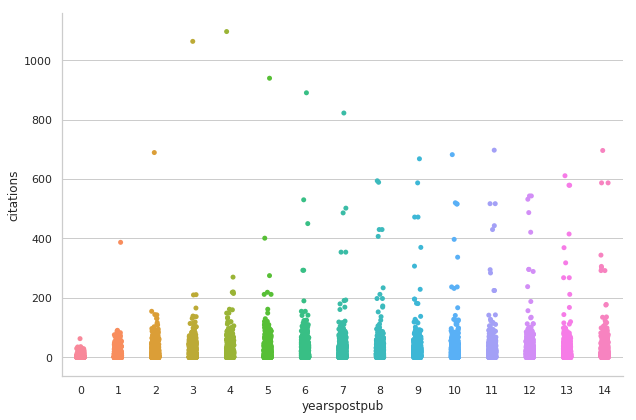

In [439]:
g = sns.catplot(data=melted, x='yearspostpub', y='citations', height=6, aspect=1.5)

## Citation count by year-post-pub, colored by decade of Nobel prize

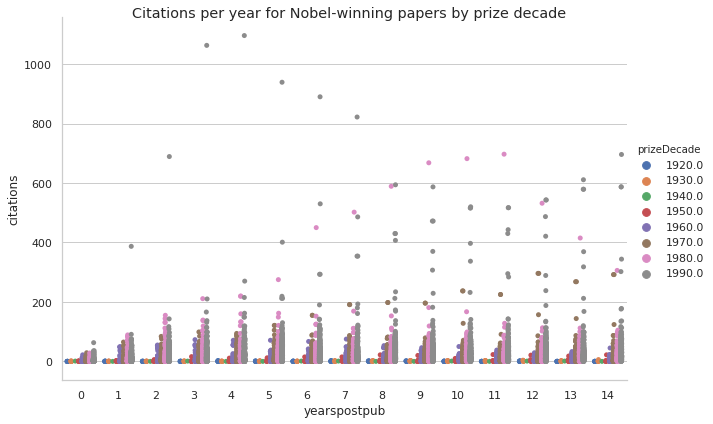

<Figure size 864x576 with 0 Axes>

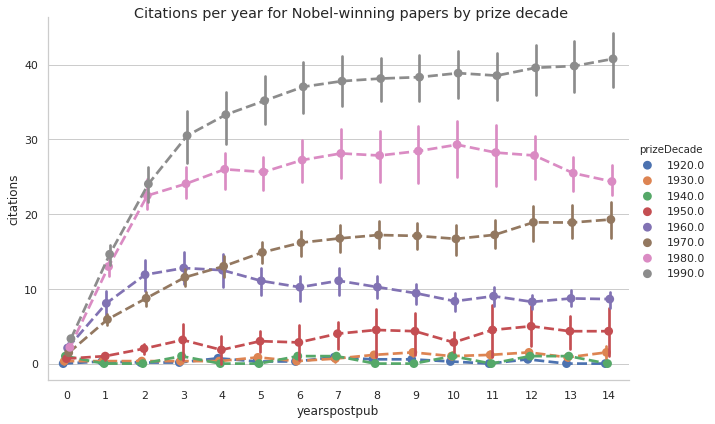

In [440]:
g = sns.catplot(data=melted, x='yearspostpub', y='citations', hue='prizeDecade', kind='strip', 
                linestyles='--', legend_out=True, dodge=True, height=6, aspect=1.5)
title = "Citations per year for Nobel-winning papers by prize decade"
_ = g.fig.suptitle(title)

_ = plt.figure()
g = sns.catplot(data=melted, x='yearspostpub', y='citations', hue='prizeDecade', kind='point', 
                linestyles='--', ci=58, legend_out=True, dodge=True, height=6, aspect=1.5)
title = "Citations per year for Nobel-winning papers by prize decade"
_ = g.fig.suptitle(title)

## Citation count by year-post-pub, colored by decade of publication

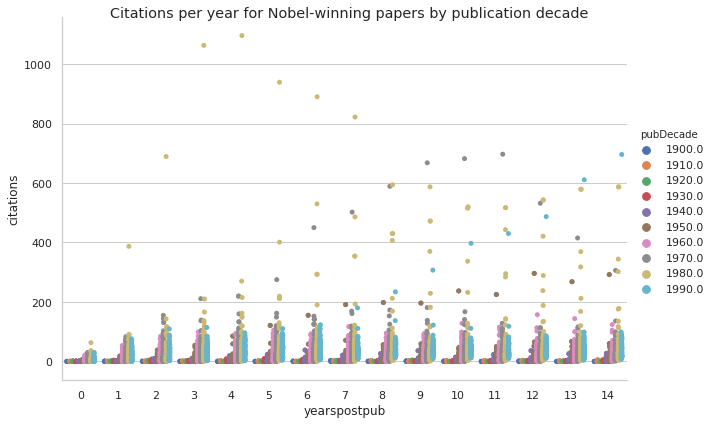

<Figure size 864x576 with 0 Axes>

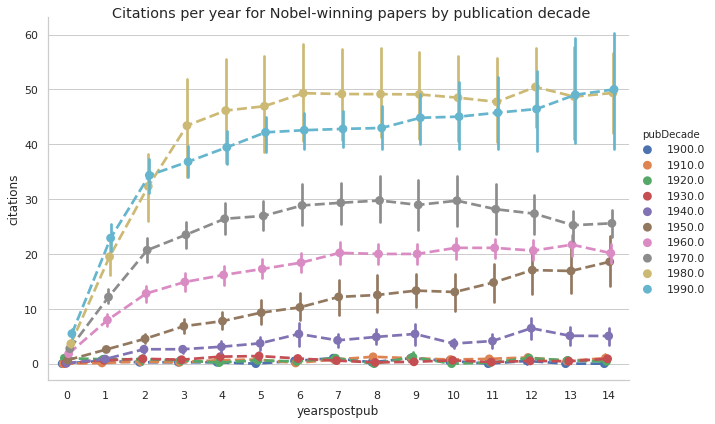

In [441]:
g = sns.catplot(data=melted, x='yearspostpub', y='citations', hue='pubDecade', kind='strip', 
                linestyles='--', legend_out=True, dodge=True, height=6, aspect=1.5)
title = "Citations per year for Nobel-winning papers by publication decade"
_ = g.fig.suptitle(title)

_ = plt.figure()
g = sns.catplot(data=melted, x='yearspostpub', y='citations', hue='pubDecade', kind='point', 
                linestyles='--', ci=68, legend_out=True, dodge=True, height=6, aspect=1.5)
title = "Citations per year for Nobel-winning papers by publication decade"
_ = g.fig.suptitle(title)

## Citation count by year-post-pub, colored by category of Nobel prize

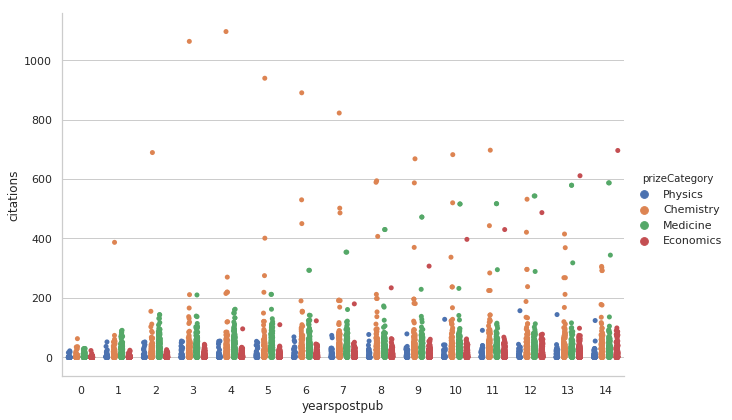

<Figure size 864x576 with 0 Axes>

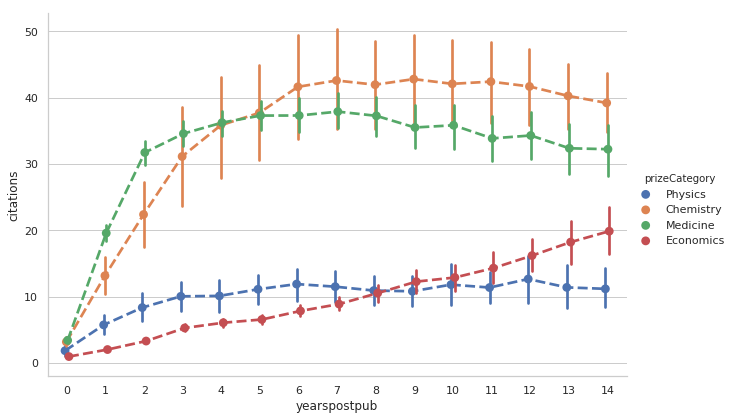

In [442]:
g = sns.catplot(data=melted, x='yearspostpub', y='citations', hue='prizeCategory', kind='strip', 
                linestyles='--', legend_out=True, dodge=True, height=6, aspect=1.5)


_ = plt.figure()
g = sns.catplot(data=melted, x='yearspostpub', y='citations', hue='prizeCategory', kind='point', 
                linestyles='--', ci=68, legend_out=True, dodge=True, height=6, aspect=1.5)

## Citation count by year-post-pub, colored by decade, divided by category

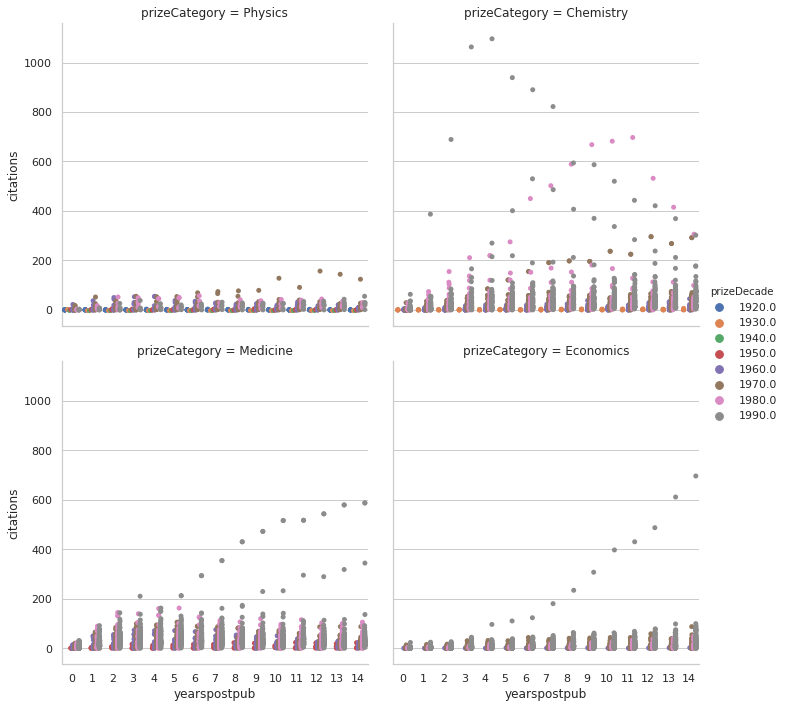

<Figure size 864x576 with 0 Axes>

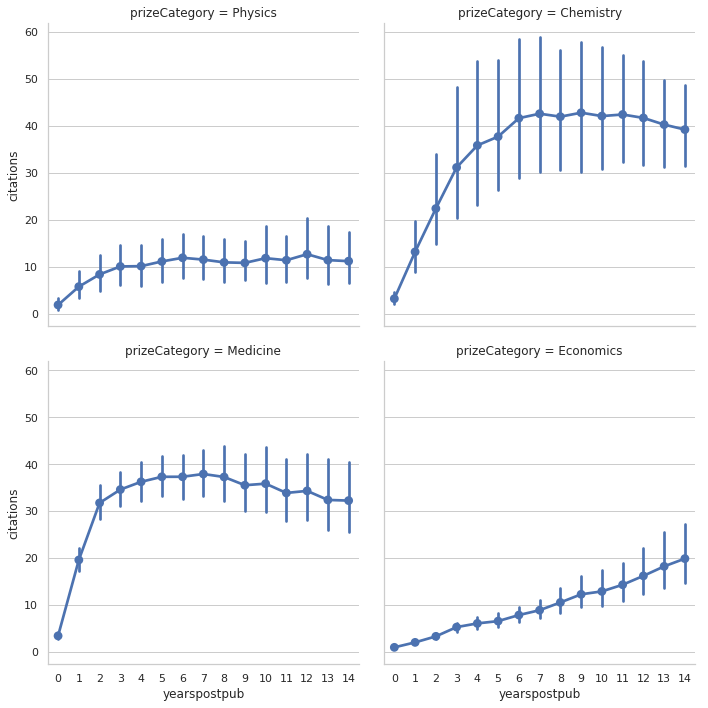

In [443]:
g = sns.catplot(data=melted.loc[melted['prizeCategory']!='Literature',:], 
                x='yearspostpub', y='citations', hue='prizeDecade', col='prizeCategory',
                kind='strip', col_wrap=2, dodge=True)

plt.figure()
g = sns.catplot(data=melted.loc[melted['prizeCategory']!='Literature',:], 
                x='yearspostpub', y='citations', col='prizeCategory',
                kind='point', col_wrap=2)

# Map Nobel citation patterns onto previous innovation-space

## Load non-Nobel data

In [478]:
# Import non-Nobel citation data
df = pd.read_csv('/tmp/data/result/top_citations_over_time.csv')
name_columns = ['title', 'id'] 

df = relabel_columns(df)

df = df[citation_columns + name_columns]
X = df[citation_columns].values

mask = (df[7] > df[14]) 
df['type'] = 'Venter-esque'
df.loc[~mask,'type'] = 'Botstein-esque'

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,title,id,type
0,1,21,114,281,487,779,1019,1215,1558,1881,2169,2473,2705,3081,3283,A rapid and sensitive method for the quantitat...,6e48427c-9d70-4d57-b3af-dc4f02330f7c,Botstein-esque
1,2170,2666,3393,3721,3788,3896,6456,6173,6951,7386,7361,6947,6297,6112,6152,Molecular cloning : a laboratory manual,a3aed21d-9e15-4a61-90df-fc39285bf7f3,Venter-esque
2,197,234,268,333,302,397,422,565,572,740,885,927,1099,1184,1453,Statistical power analysis for the behavioral ...,262ee906-bf66-4dec-bfba-90e89fa9303c,Botstein-esque
3,419,409,458,572,619,649,682,806,881,1034,1142,1393,1504,1710,2031,Standard methods for the examination of water ...,831ff9cf-6c77-415b-a5e1-a57b16bbb7d9,Botstein-esque
4,10,8,109,342,717,1207,1754,2342,2921,3566,4210,5203,5820,6483,6816,Analysis of relative gene expression data usin...,2701c2a9-b7cb-4a52-931f-05b17ee7afcf,Botstein-esque


In [484]:
# PCA Analysis of Citation Patterns 
pca = PCA(n_components=4)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
df['pca-four'] = pca_result[:,3]

nobel_values = ndf.loc[:,citation_columns].values
nobel_result = pca.transform(nobel_values)
ndf['pca-one'] = nobel_result[:,0]
ndf['pca-two'] = nobel_result[:,1] 
ndf['pca-three'] = nobel_result[:,2]
ndf['pca-four'] = nobel_result[:,3]

melted = ndf.append(df).melt(
    id_vars=other_columns, 
    value_vars=['pca-one', 'pca-two', 'pca-three', 'pca-four'])
    
melted.head()

,title,year,numCitations,prizeName,prizeYear,prizeCategory,prizeBirth,prizeDeath,prizeDecade,pubDecade,type,variable,value
0,Über die von der molekularkinetischen Theorie ...,1905.0,1944.0,Albert Einstein,1921.0,Physics,1879.0,1955.0,1920.0,1900.0,Nobel,pca-one,-300.648459
1,Eine neue Bestimmung der Moleküldimensionen,1906.0,1289.0,Albert Einstein,1921.0,Physics,1879.0,1955.0,1920.0,1900.0,Nobel,pca-one,-300.049674
2,Zur Elektrodynamik bewegter Körper,1905.0,1132.0,Albert Einstein,1921.0,Physics,1879.0,1955.0,1920.0,1900.0,Nobel,pca-one,-300.199682
3,Investigations on the theory of the Brownian m...,1915.0,1084.0,Albert Einstein,1921.0,Physics,1879.0,1955.0,1920.0,1910.0,Nobel,pca-one,-301.153597
4,Über einen die Erzeugung und Verwandlung des L...,1905.0,719.0,Albert Einstein,1921.0,Physics,1879.0,1955.0,1920.0,1900.0,Nobel,pca-one,-298.789678


In [489]:
sns.scatterplot(x='pca-two', y='pca-three', data=melted)

ValueError: Could not interpret input 'pca-two'

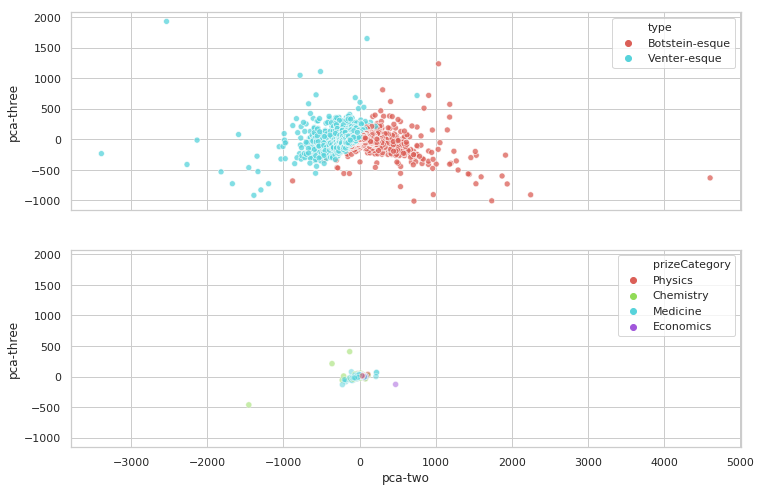

In [486]:


fig, ax = plt.subplots(2,1, sharey=True, sharex=True) 
sns.scatterplot(
    x="pca-two", y="pca-three",
    palette=sns.color_palette("hls",2),
    data=df,
    legend="full",
    alpha=0.75,
    hue='type',
    ax=ax[0]
)

sns.scatterplot(
    x="pca-two", y="pca-three",
    palette=sns.color_palette("hls",ndf['prizeCategory'].nunique()),
    data=ndf,
    legend="full",
    alpha=0.5,
    hue='prizeCategory',
    ax=ax[1]
)
    

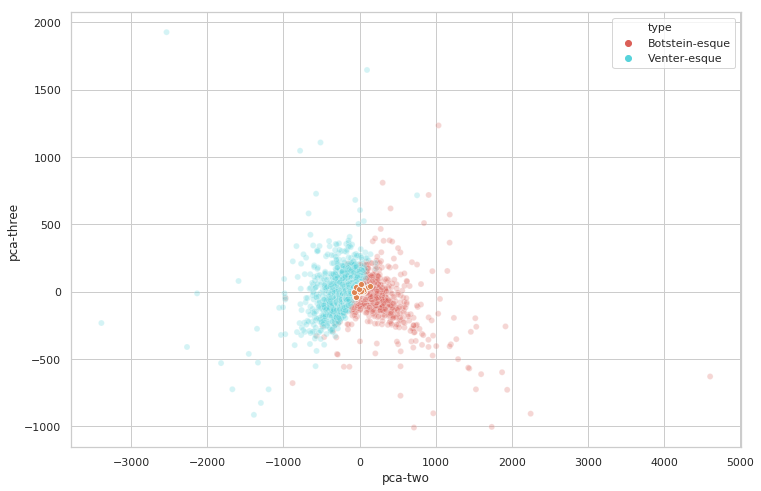

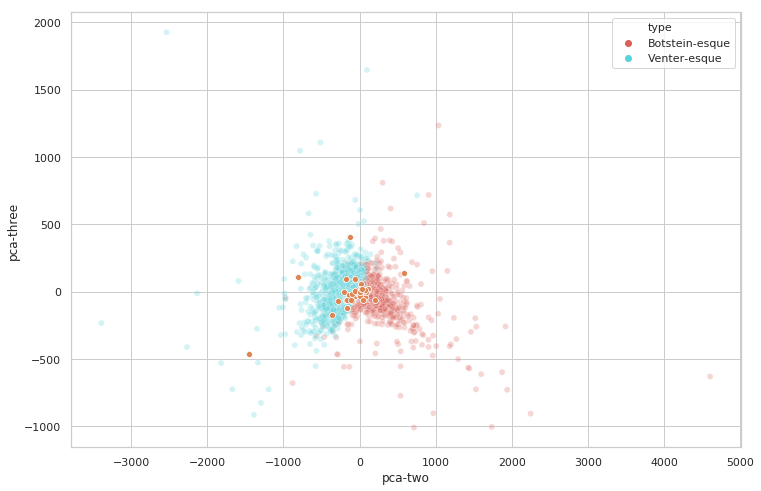

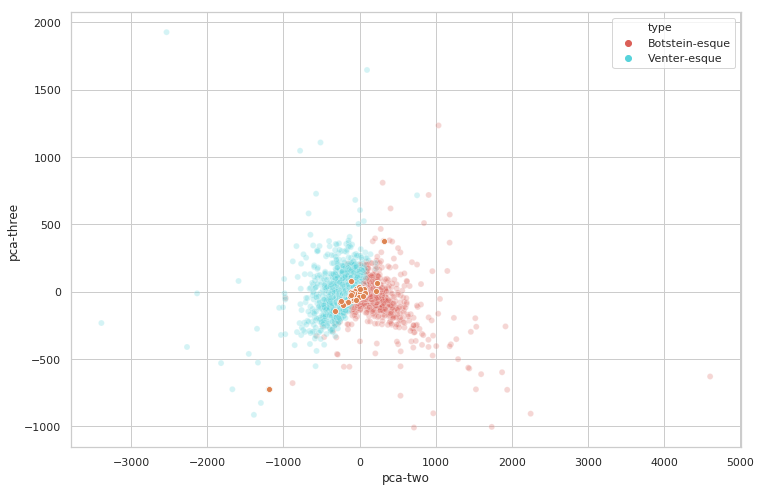

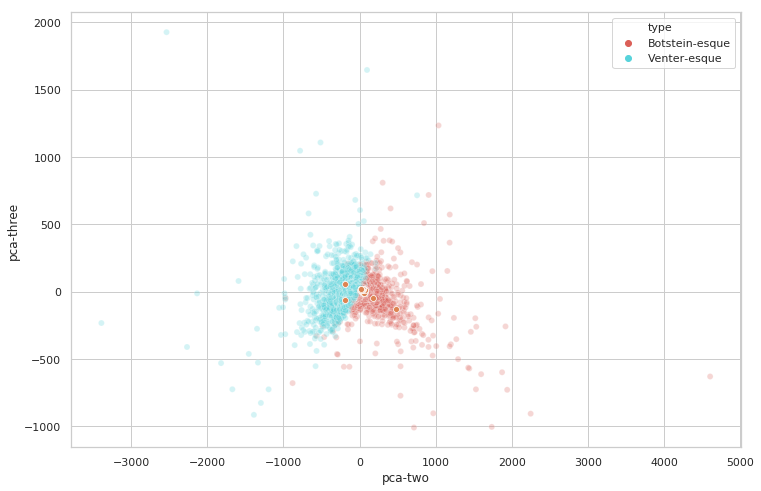

In [488]:
for prize_cat in ['Physics', 'Chemistry', 'Medicine', 'Economics']:
    plt.figure()
    sns.scatterplot(
        x="pca-two", y="pca-three",
        palette=sns.color_palette("hls",2),
        data=pcadf.loc[pcadf['type']!='Nobel',:],
        legend="full",
        alpha=0.25,
        hue='type'
    )

    sns.scatterplot(
        x="pca-two", y="pca-three",
        palette=sns.color_palette("hls",1),
        data=pcadf.loc[(pcadf['type']=='Nobel') & (pcadf['prizeCategory']==prize_cat),:],
        legend="full",
        alpha=1,
    )

In [278]:
newdf = df.loc[:,citation_columns].append(ndf[citation_columns])

newdf['type'] = 'Nobel'
newdf.iloc[0:df.shape[0],-1] = df['type']

newdf.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,type
0,1.0,21.0,114.0,281.0,487.0,779.0,1019.0,1215.0,1558.0,1881.0,2169.0,2473.0,2705.0,3081.0,3283.0,Botstein-esque
1,2170.0,2666.0,3393.0,3721.0,3788.0,3896.0,6456.0,6173.0,6951.0,7386.0,7361.0,6947.0,6297.0,6112.0,6152.0,Venter-esque
2,197.0,234.0,268.0,333.0,302.0,397.0,422.0,565.0,572.0,740.0,885.0,927.0,1099.0,1184.0,1453.0,Botstein-esque
3,419.0,409.0,458.0,572.0,619.0,649.0,682.0,806.0,881.0,1034.0,1142.0,1393.0,1504.0,1710.0,2031.0,Botstein-esque
4,10.0,8.0,109.0,342.0,717.0,1207.0,1754.0,2342.0,2921.0,3566.0,4210.0,5203.0,5820.0,6483.0,6816.0,Botstein-esque


In [254]:
# PCA Analysis of Citation Patterns 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(newdf[citation_columns].values)
newdf['pca-one'] = pca_result[:,0]
newdf['pca-two'] = pca_result[:,1] 
newdf['pca-three'] = pca_result[:,2]
for i in range(3):
    print('Explained variance of principal component {}: {:.2%}'.format(
        i+1, pca.explained_variance_ratio_[i]))

Explained variance of principal component 1: 85.80%
Explained variance of principal component 2: 10.17%
Explained variance of principal component 3: 1.96%


ValueError: Could not interpret input 'pca-one'

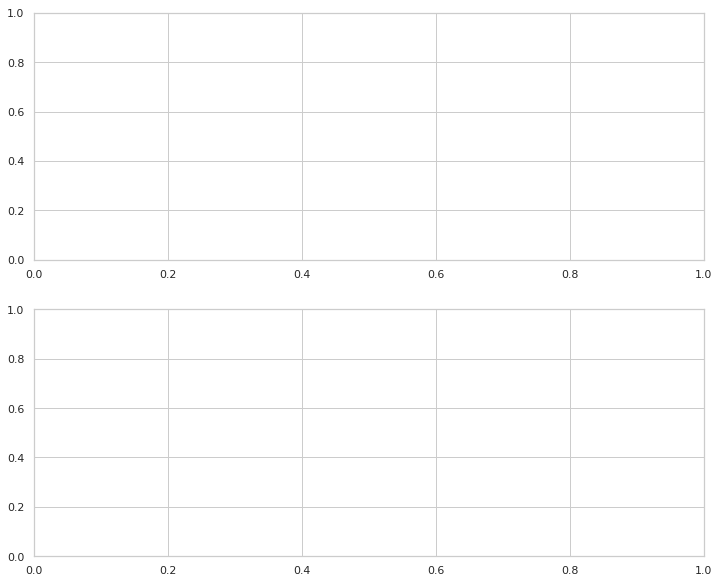

In [279]:
f, axes = plt.subplots(2,1)
f.set_size_inches(12,10)

sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls",newdf['type'].nunique()),
    data=newdf,
    legend="full",
    alpha=0.75,
    hue="type", 
    ax=axes[0]
)

# Plot two components
sns.scatterplot(
    x="pca-two", y="pca-three",
    palette=sns.color_palette("hls",newdf['type'].nunique()),
    data=newdf,
    legend=None,
    alpha=0.75,
    hue="type",
    ax=axes[1]
)

In [ ]:
for p in [2,35,55]:
    
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=250)
    tsne_results = tsne.fit_transform(pcadf[citation_columns].values)

    pcadf['tsne-2d-one'] = tsne_results[:,0]
    pcadf['tsne-2d-two'] = tsne_results[:,1]

    plt.figure()
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="type",
        palette=sns.color_palette("hls",2),
        data=pcadf.loc[pcadf['type']!='Nobel'],
        legend="full",
        alpha=0.1
    )
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        palette=sns.color_palette("hls",pcadf['prizeCategory'].nunique()),
        data=pcadf.loc[pcadf['type']=='Nobel'],
        legend="full",
        hue="prizeCategory",
        alpha=1
    )
    plt.show()